# US Election Prediction Using Machine Learning - Rani Maklada

### We have been provided with data regarding US elections, general county information, life expectancies, economic data and more.

#### This assignment will be focused on the elections to the House of Representatives that occur every other year. Furthermore, rather than attempting to estimate how each congressional district within a state voted, we will be interested in the overall number of votes per state (voter turnout) and who had more votes in a particular state per election, a Democrat, or a Republican.

# Table of Contents

### A [Data Exploration and Pre-processing](#sectionA)

### B [Dimensionality Reduction](#sectionB)

### C [Regression](#sectionC)

### D [Classification](#sectionD)

# Section A (Data Exploration and Pre-processing) <a class="anchor" id="sectionA"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import plot_confusion_matrix
# decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# model evaluation
from sklearn.metrics import accuracy_score, mean_squared_error
# adaboost
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
# KNN
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# random forest
from sklearn.ensemble import RandomForestClassifier
RSEED = 10
import CountyData
import EconomicData
import GeneralDemographicData
import LifeExpectancyData
import USElectionResults19762020
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from sklearn.manifold._t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap

# model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [2]:
landarea = pd.read_csv(r'CountyData\5296US_landarea.csv')
pop = pd.read_csv(r'CountyData\5296US_pop.csv')
waterarea = pd.read_csv(r'CountyData\5296US_waterarea.csv')

In [3]:
pop.head()

,FIPS,State,County,Date,Population
0,1001,Alabama,Autauga,1990,34222
1,1003,Alabama,Baldwin,1990,98280
2,1005,Alabama,Barbour,1990,25417
3,1007,Alabama,Bibb,1990,16576
4,1009,Alabama,Blount,1990,39248


In [4]:
waterarea.head()

,FIPS,State,County,Water Area
0,1001,Alabama,Autauga,22.0
1,1003,Alabama,Baldwin,1115.1
2,1005,Alabama,Barbour,50.7
3,1007,Alabama,Bibb,8.1
4,1009,Alabama,Blount,12.9


In [5]:
landarea.head()

,FIPS,State,County,Land Area
0,1001,Alabama,Autauga,1543.7
1,1003,Alabama,Baldwin,4135.0
2,1005,Alabama,Barbour,2292.1
3,1007,Alabama,Bibb,1611.9
4,1009,Alabama,Blount,1672.3


Merge demographics into one table

In [6]:
countyData = pop
countyData = countyData.join(landarea['Land Area'])
countyData = countyData.join(waterarea['Water Area'])

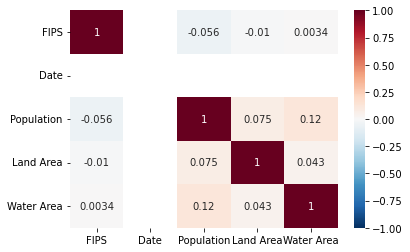

In [7]:
sns.heatmap(data=countyData.corr(), cmap= 'RdBu_r', vmin=-1, vmax=1, annot=True, annot_kws={"size":10})
plt.show()

<h3>Population in Each State Based on 1990</h3>

In [8]:
state_sum_group = countyData.groupby(['State'])[['Land Area','Population']].sum()

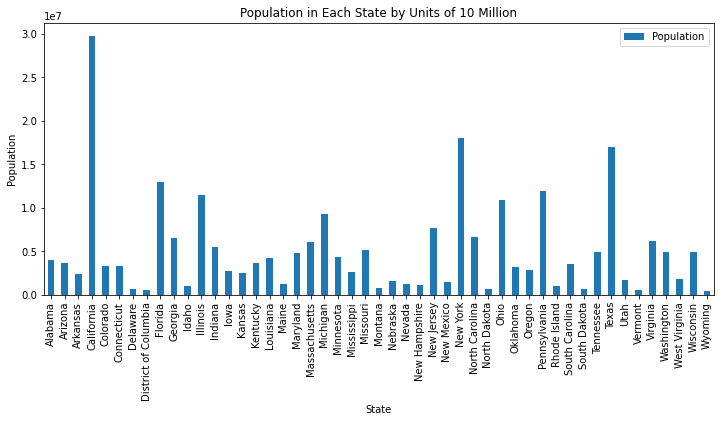

In [9]:
state_sum_group.plot.bar(y='Population',ylabel='Population', title='Population in Each State by Units of 10 Million',figsize = (12,5))
plt.show()

<h3>Land Area of States</h3>

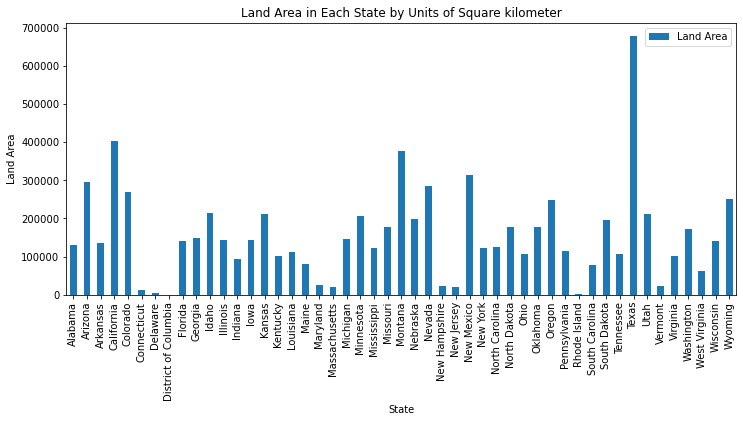

In [10]:
state_sum_group.plot.bar(y='Land Area',ylabel='Land Area',title='Land Area in Each State by Units of Square kilometer',figsize = (12,5))
plt.show()

<h3>Density of States</h3>

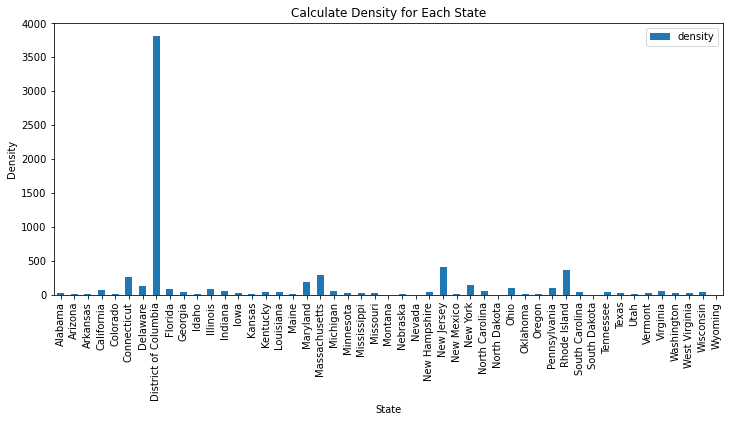

In [11]:
state_sum_group['density'] = state_sum_group['Population'] / state_sum_group['Land Area']
state_sum_group.plot.bar(y='density',ylabel='Density', title='Calculate Density for Each State',figsize = (12,5))
plt.show()

<h3>Dow Jones - Economic Data</h3>

In [12]:
Dow_Jones = pd.read_csv(r'EconomicData\BCB-UDJIAD1.csv').iloc[::-1]
Median_Household_Income = pd.read_csv(r'EconomicData\county1.csv')

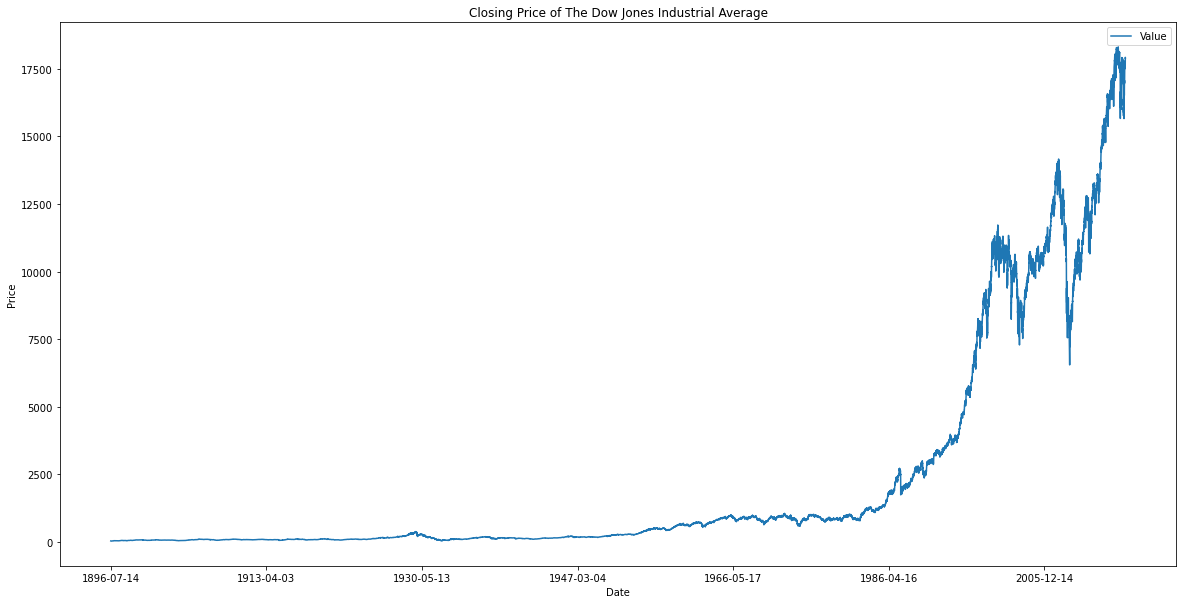

In [13]:
Dow_Jones.plot(x='Date',ylabel='Price',y='Value',title='Closing Price of The Dow Jones Industrial Average',figsize = (20,10))
plt.show()

In [14]:
county_complete = pd.read_csv(r'GeneralDemographicData\county_complete.csv')

In [15]:
life_expectancy = pd.read_csv(r'LifeExpectancyData\IHME_USA_LIFE_EXPECTANCY_1987_2007_Y2011M06D16.csv')

In [16]:
house_data = pd.read_csv(r'USElectionResults19762020\1976-2020-house.csv')
president_data = pd.read_csv(r'USElectionResults19762020\1976-2020-president.csv')
senate_data = pd.read_csv(r'USElectionResults19762020\1976-2020-senate.csv')

In [17]:
groups = pd.get_dummies(house_data[['party','year']][(house_data['party']=='DEMOCRAT') | (house_data['party']=='REPUBLICAN')],columns=['party']).groupby(['year']).sum()

In [18]:
house_data.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version,fusion_ticket
0,1976,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,False,False,BILL DAVENPORT,DEMOCRAT,False,TOTAL,58906,157170,False,20220331,False
1,1976,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,False,False,JACK EDWARDS,REPUBLICAN,False,TOTAL,98257,157170,False,20220331,False
2,1976,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,False,False,WRITEIN,NaN,True,TOTAL,7,157170,False,20220331,False
3,1976,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,False,False,J CAROLE KEAHEY,DEMOCRAT,False,TOTAL,66288,156362,False,20220331,False
4,1976,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,False,False,"WILLIAM L ""BILL"" DICKINSON",REPUBLICAN,False,TOTAL,90069,156362,False,20220331,False


<h3>Electoral Votes over the years for the House Members - DEMOCRAT vs REPUBLICAN</h3>

In [19]:
tmp = house_data[['year','state','party','candidatevotes']][(house_data['party']=='DEMOCRAT') | (house_data['party']=='REPUBLICAN')]
tmp['DEMOCRAT'] = 0
tmp['REPUBLICAN'] = 0
for i in tmp.index:
    tmp[tmp['party'].loc[i]].loc[i] = tmp['candidatevotes'].loc[i]
tmp = tmp.groupby(['year','state']).sum().reset_index()
tmp['Classified'] = ''
for index in tmp.index:
    if tmp['DEMOCRAT'].loc[index] > tmp['REPUBLICAN'].loc[index]:
        tmp['Classified'].loc[index] = 'D'
    else:
        tmp['Classified'].loc[index] = 'R'
tmp = pd.get_dummies(tmp[['year','state','Classified']],columns=['Classified']).groupby(['year']).sum()
tmp.rename(columns = {'Classified_D':'DEMOCRAT', 'Classified_R':'REPUBLICAN'}, inplace = True)

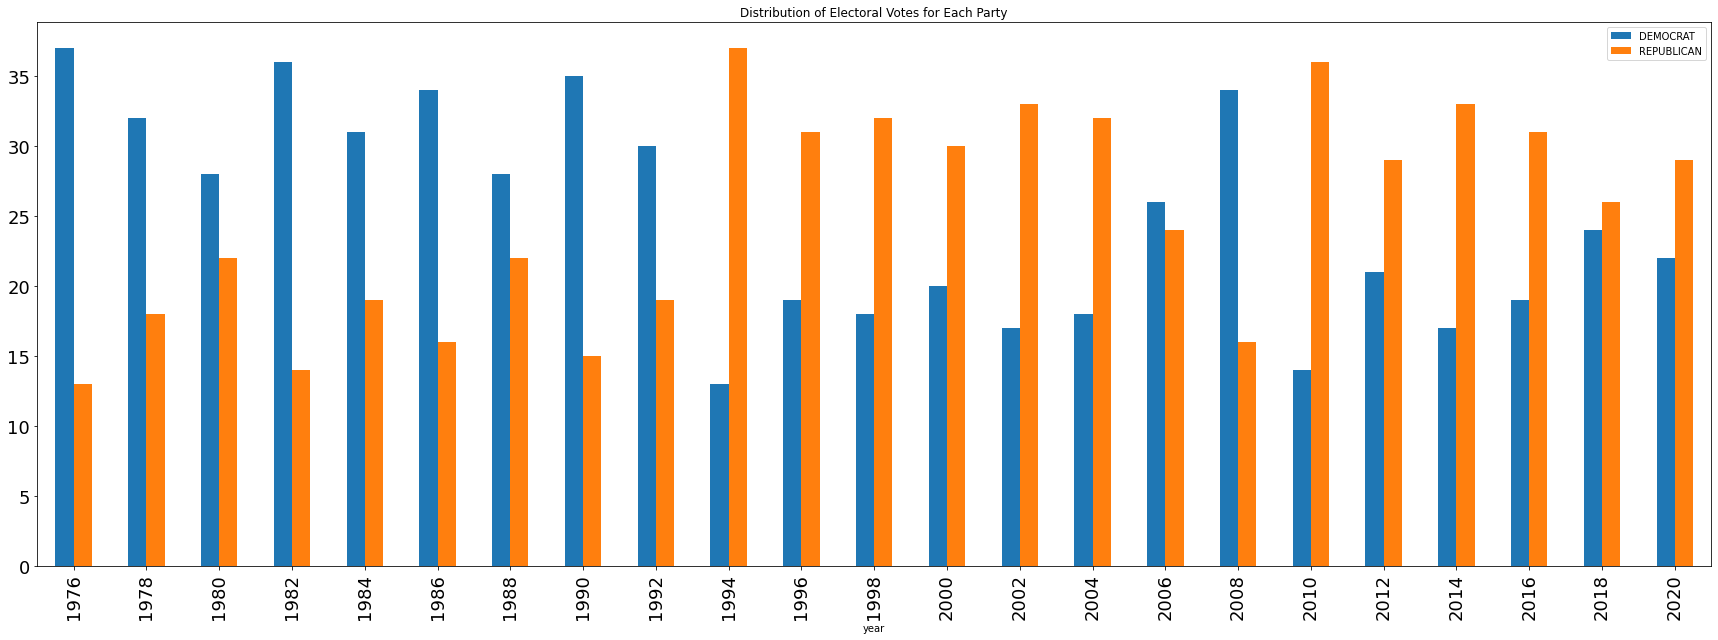

In [20]:
tmp.plot.bar(figsize = (30,10),fontsize=18, title='Distribution of Electoral Votes for Each Party')
plt.show()

<h3>President Elections Over The Years - DEMOCRAT vs REPUBLICAN</h3>

In [21]:
tmp = president_data[['year','state','party_simplified','candidatevotes']][(president_data['party_simplified']=='DEMOCRAT') | (president_data['party_simplified']=='REPUBLICAN')]
tmp['DEMOCRAT'] = 0
tmp['REPUBLICAN'] = 0
for i in tmp.index:
    tmp[tmp['party_simplified'].loc[i]].loc[i] = tmp['candidatevotes'].loc[i]
tmp = tmp.groupby(['year','state']).sum().reset_index()
tmp['Classified'] = ''
for index in tmp.index:
    if tmp['DEMOCRAT'].loc[index] > tmp['REPUBLICAN'].loc[index]:
        tmp['Classified'].loc[index] = 'D'
    else:
        tmp['Classified'].loc[index] = 'R'
tmp = pd.get_dummies(tmp[['year','state','Classified']],columns=['Classified']).groupby(['year']).sum()
tmp.rename(columns = {'Classified_D':'DEMOCRAT', 'Classified_R':'REPUBLICAN'}, inplace = True)

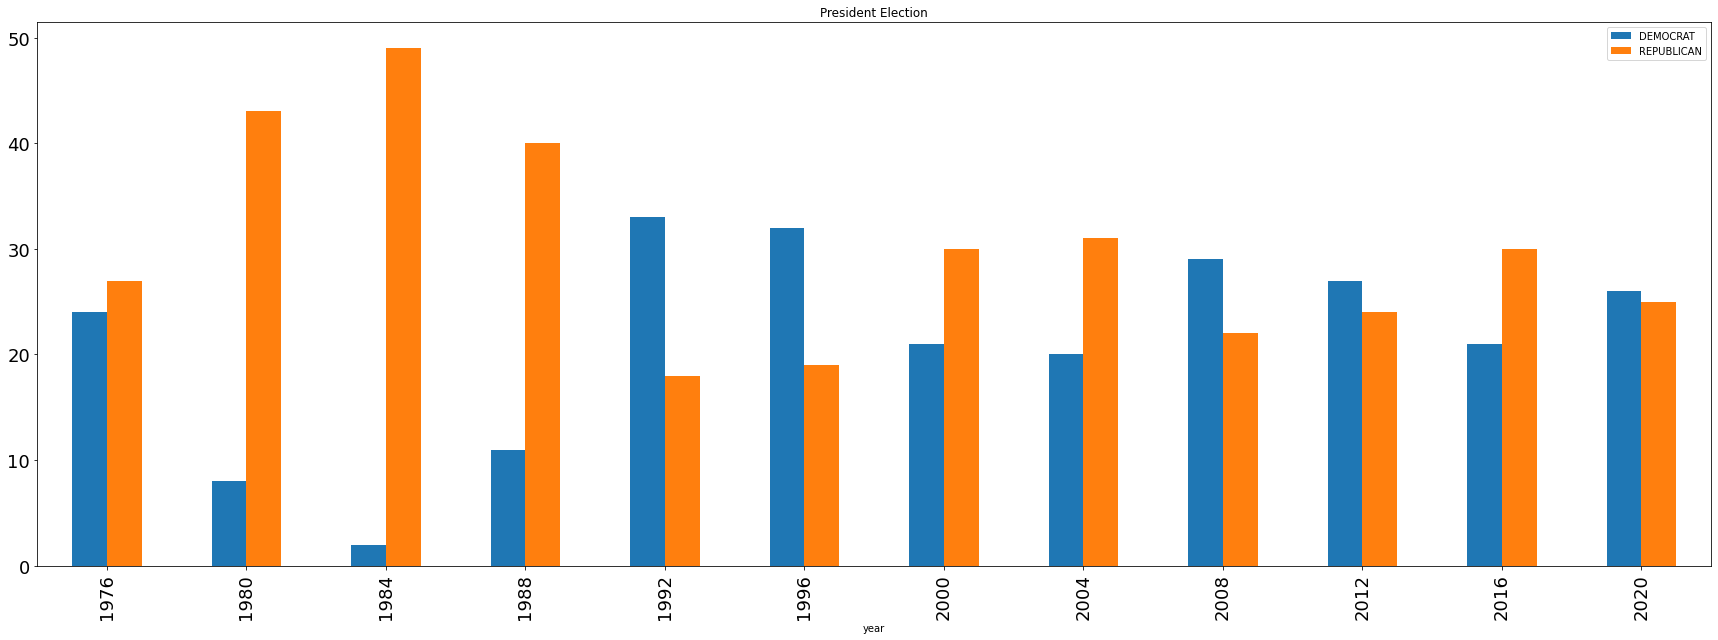

In [22]:
tmp.plot.bar(figsize = (30,10),fontsize=18, title='President Election')
plt.show()

<h3>Life expectancy ratio of men and women over the years</h3>

<AxesSubplot:xlabel='Male life expectancy (years)', ylabel='Female life expectancy (years)'>

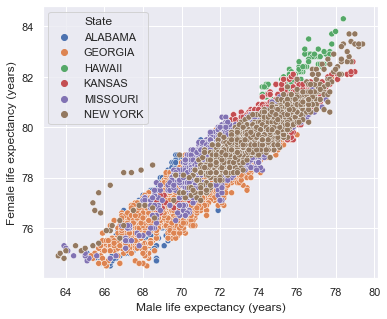

In [23]:
sns.set(rc={"figure.figsize":(6, 5)})
life_ex = life_expectancy[(life_expectancy['State']=='ALABAMA')|(life_expectancy['State']=='HAWAII')
                         |(life_expectancy['State']=='KANSAS')|(life_expectancy['State']=='NEW YORK')
                         |(life_expectancy['State']=='GEORGIA')|(life_expectancy['State']=='MISSOURI')]
sns.scatterplot(data=life_ex,x='Male life expectancy (years)',y='Female life expectancy (years)', hue='State', legend='full')

Life expectancy increases over time

# Section B (Dimensionality Reduction) <a class="anchor" id="sectionB"></a>

In [24]:
life_expectancyXLSX = pd.read_excel(r'LifeExpectancyData\IHME_USA_LIFE_EXPECTANCY_1987_2007_Y2011M06D16.XLSX')

We selected 4 features from table life_expectancyXLSX

In [25]:
life_expectancyXLSX = life_expectancyXLSX[['fips','State','County','Year',
                                     'Male life expectancy (years)',
                                     'Female life expectancy (years)',
                                    'Male life expectancy change 1997 to 2007 (years)',
                                    'Female life expectancy change 1997 to 2007 (years)']]

We selected 3 features from table county_complete

In [26]:
county_complete_selected = county_complete[['fips','state','name','hs_grad_2019',
                                           'bachelors_2019','black_2019']]

In [27]:
county_complete_selected = county_complete_selected[(county_complete_selected['state'] == 'California') |
                                                   (county_complete_selected['state'] == 'Florida') |
                                                   (county_complete_selected['state'] == 'South Dakota')|
                                                   (county_complete_selected['state'] == 'Wyoming')]
county_complete_selected.rename(columns = {'state':'State'}, inplace = True)

We have 1 feature from table landarea

In [28]:
landarea_selected = landarea[(landarea['State'] == 'California') |
                                                   (landarea['State'] == 'Florida') |
                                                   (landarea['State'] == 'South Dakota')|
                                                   (landarea['State'] == 'Wyoming')]
landarea_selected.rename(columns = {'FIPS':'fips'}, inplace = True)

In [29]:
life_expectancyXLSX['State'] = life_expectancyXLSX['State'].str.title()
life_expectancyXLSX = life_expectancyXLSX[(life_expectancyXLSX['State'] == 'California') |
                                                   (life_expectancyXLSX['State'] == 'Florida') |
                                                   (life_expectancyXLSX['State'] == 'South Dakota')|
                                                   (life_expectancyXLSX['State'] == 'Wyoming')]
life_expectancyXLSX = life_expectancyXLSX.groupby(['State','County']).mean().reset_index()
life_expectancyXLSX = life_expectancyXLSX.drop(columns=['Year'])

In [30]:
life_expectancyXLSX['fips'] = life_expectancyXLSX['fips'].astype(int)

In [31]:
life_expectancyXLSX = life_expectancyXLSX.set_index('fips')
county_complete_selected = county_complete_selected.set_index('fips')
landarea_selected = landarea_selected.set_index('fips')

In [32]:
life_expectancyXLSX = life_expectancyXLSX.drop(columns=['State','County'])
county_complete_selected = county_complete_selected.drop(columns=['State','name'])

After filtering the data for the relevant states we merge the features into one table

In [33]:
Data_Reduction = pd.concat([landarea_selected,life_expectancyXLSX, county_complete_selected], axis=1, join="inner")

Check missing data

In [34]:
Data_Reduction.isnull().values.any()

False

In [35]:
Data_Reduction.reset_index(inplace=True)
Data_Reduction = Data_Reduction.drop(columns=['fips'])

Checks the ratio between the features

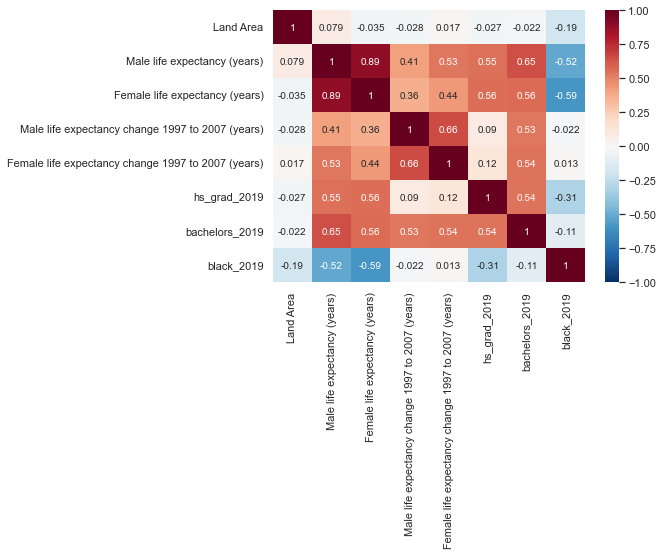

In [36]:
plt.figure(figsize = (7,5))
sns.heatmap(data=Data_Reduction.corr(), cmap= 'RdBu_r', vmin=-1, vmax=1, annot=True, annot_kws={"size":10})
plt.show()

<h3>PCA algorithm</h3>

In [37]:
x = StandardScaler().fit_transform(Data_Reduction.drop(columns=['State','County']))
y = Data_Reduction.loc[:,['State']].values
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [38]:
finalDf = pd.concat([principalDf, Data_Reduction[['State']]], axis = 1)

In [39]:
finalDf['State'].unique()

array(['California', 'Florida', 'South Dakota', 'Wyoming'], dtype=object)

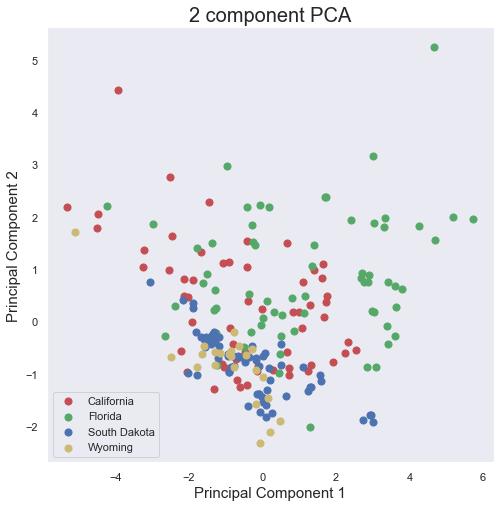

In [40]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
states = ['California', 'Florida', 'South Dakota', 'Wyoming']
colors = ['r', 'g', 'b','y']
for target, color in zip(states,colors):
    indicesToKeep = finalDf['State'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(states)
ax.grid()

<h3>t-SNE algorithm</h3>

In [41]:
tsne = TSNE()
X_embedded = tsne.fit_transform(x)

<AxesSubplot:>

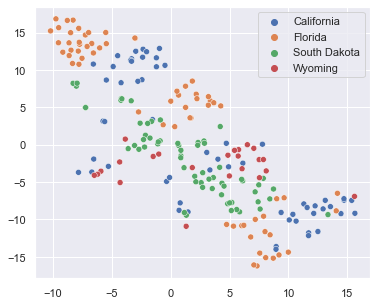

In [42]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=np.ravel(y), legend='full')

In [43]:
Data_Reduction.head(n=1)

,State,County,Land Area,Male life expectancy (years),Female life expectancy (years),Male life expectancy change 1997 to 2007 (years),Female life expectancy change 1997 to 2007 (years),hs_grad_2019,bachelors_2019,black_2019
0,California,Alameda,1910.1,74.371429,80.0,3.5,2.3,88.4,47.4,10.6


In [44]:
X_cls = Data_Reduction.drop(columns=['State','County'])
y_cls = Data_Reduction[['State']]

Activate RandomForestClassifier to find features effectiveness in separating the four states

In [45]:
# define model
rf = RandomForestClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 4, 6],
    'n_estimators': [20, 50, 80]
}

# define grid search
grid_search = GridSearchCV(estimator=rf, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_cls, y_cls)

# get best estimator
best = grid_search.best_estimator_

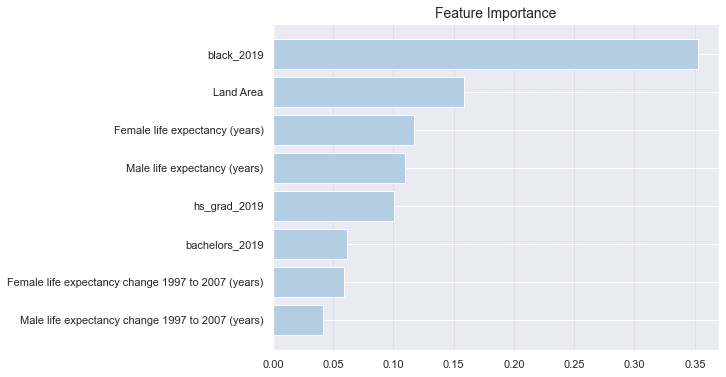

In [46]:
# get feature importance
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_cls, y_cls).feature_importances_, 
                   index=X_cls.columns, columns=['Importance']).sort_values('Importance')
imp = imp[imp['Importance'] > 0]
# plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(range(0, len(imp)), imp['Importance'], color='#b3cde3')
plt.grid(axis='x', alpha=0.5, color='lightgrey')
plt.yticks(range(0, len(imp)), imp.index)
plt.title('Feature Importance', fontsize=14)
plt.show()

<h4>Most effective features are:</h4>

- black_2019
- Land Area

<AxesSubplot:xlabel='black_2019', ylabel='Land Area'>

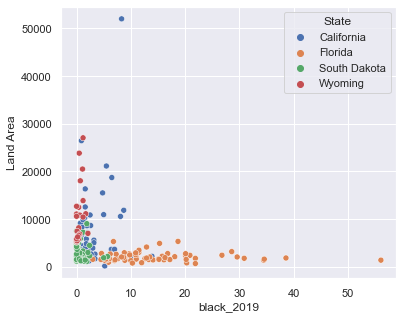

In [47]:
sns.scatterplot(data=Data_Reduction,x='black_2019',y='Land Area', hue='State', legend='full')

<h4>Least effective features are:</h4>

- Male life expectancy change 1997 to 2007 (years)
- Female life expectancy change 1997 to 2007 (years)

<AxesSubplot:xlabel='Male life expectancy change 1997 to 2007 (years)', ylabel='Female life expectancy change 1997 to 2007 (years)'>

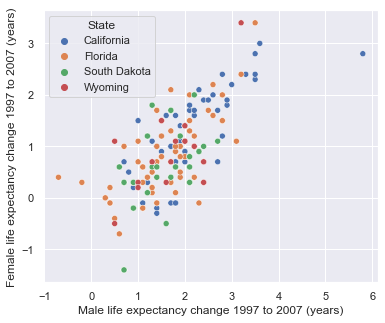

In [48]:
sns.scatterplot(data=Data_Reduction,x='Male life expectancy change 1997 to 2007 (years)',y='Female life expectancy change 1997 to 2007 (years)', hue='State', legend='full')

# Section C (Regression) <a class="anchor" id="sectionC"></a>

We have missing data to calculate the turnout - Population size and eligible voters over the years<br>
The voting percentage calculation is the number of voters divided by the number of people who eligible to vote

<h4>We will start with the population</h4>
In order to complete the data we will use the existing data<br>
and calculate the percentage growth over the years and fill in the gaps

In [49]:
pop_data = county_complete[['state','name','pop2000','pop2010','pop2012','pop2015','pop2016','pop2017']]

In [50]:
for i in range(2001,2010):
    pop_data['pop'+str(i)] = pop_data['pop'+str(i-1)]+(pop_data['pop2010']-pop_data['pop2000'])/10

In [51]:
pop_data['pop2011'] = pop_data['pop2010']+(pop_data['pop2012'] - pop_data['pop2010'])/2

In [52]:
pop_data.columns

Index(['state', 'name', 'pop2000', 'pop2010', 'pop2012', 'pop2015', 'pop2016',
       'pop2017', 'pop2001', 'pop2002', 'pop2003', 'pop2004', 'pop2005',
       'pop2006', 'pop2007', 'pop2008', 'pop2009', 'pop2011'],
      dtype='object')

In [53]:
pop_date= pop_data[['state', 'name','pop2002', 'pop2003', 'pop2004', 'pop2005',
       'pop2006', 'pop2007', 'pop2008', 'pop2009','pop2010','pop2011','pop2012']]

In [54]:
pop_date.head(n=3)

,state,name,pop2002,pop2003,pop2004,pop2005,pop2006,pop2007,pop2008,pop2009,pop2010,pop2011,pop2012
0,Alabama,Autauga County,45851.0,46941.0,48031.0,49121.0,50211.0,51301.0,52391.0,53481.0,54571,54749.0,54927.0
1,Alabama,Baldwin County,148785.0,152970.0,157155.0,161340.0,165525.0,169710.0,173895.0,178080.0,182265,186156.5,190048.0
2,Alabama,Barbour County,28721.8,28563.7,28405.6,28247.5,28089.4,27931.3,27773.2,27615.1,27457,27316.0,27175.0


<h4>Now we will calculate start voter turnout</h4>
In order to do that we will use the feture 'age_under_18_2010' from the data<br>
and calculate the percentage of people who are over the age 18 in year 2010

In [55]:
voter_turnout_2010 = county_complete[['state','name','age_under_18_2010','pop2010']]

In [56]:
voter_turnout_2010['age_over_18_2010'] = 0.01*(100 - voter_turnout_2010['age_under_18_2010'])

In [57]:
turnout_data = county_complete[['state','name']]

Now we will fill the data based on the percentage

In [58]:
for i in range(2002,2013):
    turnout_data['turnout'+str(i)] = pop_date['pop'+str(i)]*voter_turnout_2010['age_over_18_2010']

In [59]:
turnout_data = turnout_data.groupby(['state']).sum()

In [60]:
turnout_data.head(n=3)

,turnout2002,turnout2003,turnout2004,turnout2005,turnout2006,turnout2007,turnout2008,turnout2009,turnout2010,turnout2011,turnout2012
state,,,,,,,,,,,
Alabama,3444540.530,3.469850e+06,3495159.254,3.520469e+06,3545777.978,3.571087e+06,3596396.702,3.621706e+06,3647015.426,3.660039e+06,3673062.870
Alaska,473494.873,4.793206e+05,485146.384,4.909721e+05,496797.895,5.026237e+05,508449.406,5.142752e+05,522764.761,5.258649e+05,533355.360
Arizona,4012566.269,4.106388e+06,4200209.058,4.294030e+06,4387851.847,4.481673e+06,4575494.636,4.669316e+06,4763137.425,4.819394e+06,4875649.744


We need to filter the data over the relevant years

In [61]:
house_data_selected = house_data[(house_data['year'] >= 2002) & (house_data['year'] <= 2012)]

In [62]:
house_data_selected = house_data_selected.groupby(['year','state','district']).mean()

In [63]:
house_data_selected.reset_index(inplace=True)

In [64]:
house_data_selected = house_data_selected.groupby(['year','state',]).sum()

In [65]:
house_data_selected.reset_index(inplace=True)

In [66]:
total_votes_data = house_data_selected[['year','state','totalvotes']]

In [67]:
turnout_data.head(n=3)

,turnout2002,turnout2003,turnout2004,turnout2005,turnout2006,turnout2007,turnout2008,turnout2009,turnout2010,turnout2011,turnout2012
state,,,,,,,,,,,
Alabama,3444540.530,3.469850e+06,3495159.254,3.520469e+06,3545777.978,3.571087e+06,3596396.702,3.621706e+06,3647015.426,3.660039e+06,3673062.870
Alaska,473494.873,4.793206e+05,485146.384,4.909721e+05,496797.895,5.026237e+05,508449.406,5.142752e+05,522764.761,5.258649e+05,533355.360
Arizona,4012566.269,4.106388e+06,4200209.058,4.294030e+06,4387851.847,4.481673e+06,4575494.636,4.669316e+06,4763137.425,4.819394e+06,4875649.744


In [68]:
total_votes_data['state'] = total_votes_data['state'].str.title() 

In [69]:
total_votes_data.head(n=3)

,year,state,totalvotes
0,2002,Alabama,1268802.0
1,2002,Alaska,227725.0
2,2002,Arizona,1194400.0


vep - voting-eligible population in US elections

<h4>Now we calculate the turnout</h4>

In [70]:
total_votes_data['vep'] = 0

In [71]:
for index in total_votes_data.index:
    total_votes_data['vep'].loc[index] = turnout_data['turnout'+str(total_votes_data['year'].loc[index])][total_votes_data['state'].loc[index]]

In [72]:
total_votes_data['turnout'] = total_votes_data['totalvotes'] / total_votes_data['vep']

In [73]:
total_votes_data.groupby(['year']).mean()

,totalvotes,vep,turnout
year,,,
2002,1494320.920,4.355448e+06,0.379821
2004,2263825.860,4.436647e+06,0.541740
2006,1619856.566,4.517845e+06,0.394793
2008,2451725.960,4.599044e+06,0.555513
2010,1735909.200,4.681121e+06,0.399099
2012,2446900.440,4.759361e+06,0.540176


In [74]:
total_votes_data = total_votes_data.set_index(['state','year'])

In [75]:
total_votes_data['foreign_born_2010']=0
total_votes_data['hs_grad_2010']=0
total_votes_data['bachelors_2010']=0
total_votes_data['veterans_2010']=0
total_votes_data['poverty_2010']=0

We chose another 5 features from county_complete to help with the prediction

In [76]:
temp = county_complete[['state','name','foreign_born_2010','hs_grad_2010','bachelors_2010','veterans_2010','poverty_2010']]
temp = temp.groupby(['state']).mean()

In [77]:
for index in total_votes_data.index:
    state = temp.loc[index[0]]
    for column in temp.columns:
        total_votes_data[column].loc[index] = state[column]

In [78]:
total_votes_data.reset_index(inplace=True)

One more feature we decided to add, is to check if a year had a presidential election

In [79]:
president_year = set(president_data['year'].values)

In [80]:
total_votes_data['president_election']=0

In [81]:
for index in total_votes_data.index:
    if total_votes_data['year'].loc[index] in president_year:
        total_votes_data['president_election'].loc[index] = 1
    else:
        total_votes_data['president_election'].loc[index] = 0

In [82]:
states = total_votes_data[['state']]

In [83]:
total_votes_data = pd.get_dummies(total_votes_data,columns=['state'])
total_votes_data['state'] = states

In [84]:
total_votes_data.head(n=3)

,year,totalvotes,vep,turnout,foreign_born_2010,hs_grad_2010,bachelors_2010,veterans_2010,poverty_2010,president_election,...,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,state
0,2002,1268802.0,3444540.530,0.368352,2.210448,76.782090,15.392537,6090.029851,19.907463,0,...,0,0,0,0,0,0,0,0,0,Alabama
1,2002,227725.0,473494.873,0.480945,8.193103,86.593103,20.662069,2475.793103,12.293103,0,...,0,0,0,0,0,0,0,0,0,Alaska
2,2002,1194400.0,4012566.269,0.297665,10.613333,81.820000,18.053333,36147.333333,19.033333,0,...,0,0,0,0,0,0,0,0,0,Arizona


In [85]:
X_reg = total_votes_data.drop(columns=['totalvotes','turnout'])
y_reg = total_votes_data[['year','turnout','state']]
y_reg['turnout'] = y_reg['turnout']*100

In [86]:
X_reg_train = X_reg[X_reg['year'] < 2010]
X_reg_test = X_reg[X_reg['year'] >= 2010]
y_reg_train = y_reg[y_reg['year'] < 2010]
y_reg_test = y_reg[y_reg['year'] >= 2010]

In [87]:
X_reg_train.set_index(['state','year'],inplace=True)
X_reg_test.set_index(['state','year'],inplace=True)
y_reg_train.set_index(['state','year'],inplace=True)
y_reg_test.set_index(['state','year'],inplace=True)

In [88]:
models_compare = pd.DataFrame(columns=['DecisionTreeRegressor','GradientBoostingRegressor','KNeighborsRegressor'])

<h3>DecisionTreeRegressor</h3>

In [89]:
# define model
dt = DecisionTreeRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 4, 8]
}

# define grid search
grid_search = GridSearchCV(estimator=dt, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_reg_train, y_reg_train)

# get best estimator
best = grid_search.best_estimator_

In [90]:
# predict
y_pred = best.predict(X_reg_test)

In [91]:
# calculate MSE
MSE = round(mean_squared_error(y_reg_test, y_pred), 3)
models_compare['DecisionTreeRegressor'] = [MSE]
df = pd.DataFrame([MSE]).T
df = df.rename(index={0: 'Decision Tree Regressor'}, columns={0: 'MSE'})
df

,MSE
Decision Tree Regressor,28.619


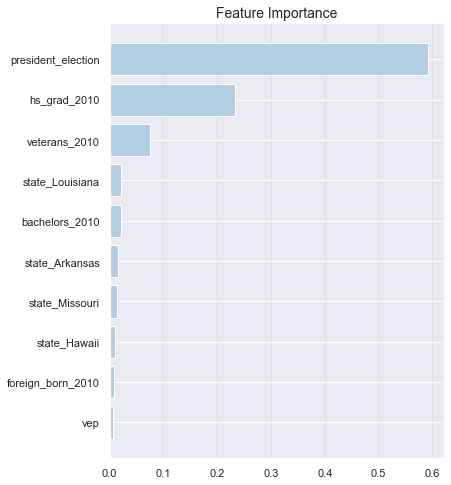

In [92]:
# get feature importance
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_reg_train, y_reg_train).feature_importances_, 
                   index=X_reg_train.columns, columns=['Importance']).sort_values('Importance')
imp = imp[imp['Importance'] > 0]
# plot feature importance
plt.figure(figsize=(6, 8))
plt.barh(range(0, len(imp)), imp['Importance'], color='#b3cde3')
plt.grid(axis='x', alpha=0.5, color='lightgrey')
plt.yticks(range(0, len(imp)), imp.index)
plt.title('Feature Importance', fontsize=14)
plt.show()

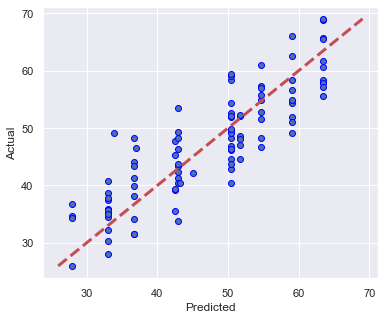

In [93]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_reg_test, edgecolors=(0, 0, 1))
ax.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

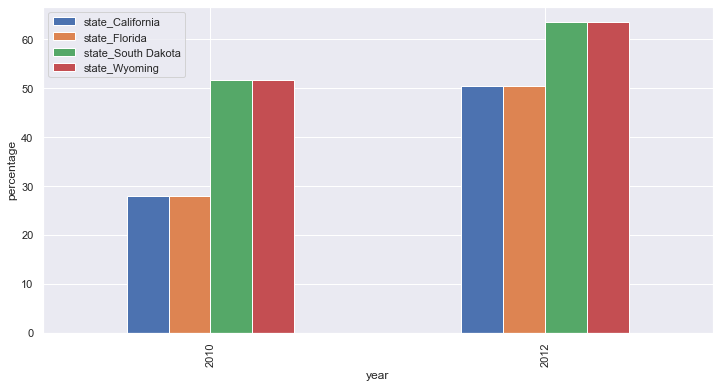

In [94]:
states_vis = X_reg_test.loc[['California', 'Florida', 'South Dakota', 'Wyoming']]
y_pred_vis = best.predict(states_vis)
states_vis['pred'] = y_pred_vis
states_vis = states_vis[['pred']]
states_vis.reset_index(inplace=True)
dummies = pd.get_dummies(states_vis,columns=['state'])
for index in states_vis.index:
    dummies['state_'+(states_vis['state'].loc[index])].loc[index] = dummies['pred'].loc[index]
dummies.groupby(['year']).sum().drop(columns=['pred']).plot.bar(figsize=(12, 6),ylabel='percentage');

In [95]:
compare = y_reg_test.copy()
compare['pred'] = y_pred
compare['deff'] = pow(compare['pred']-compare['turnout'],2)
Ranking = compare.groupby(['state']).sum() 
Ranking['Rank'] = Ranking["deff"].rank().astype('int')
Ranking[['Rank']].sort_values(by='Rank', ascending=True).tail(n=5)

,Rank
state,
Washington,46
Maine,47
Utah,48
North Carolina,49
Louisiana,50


<h3>GradientBoostingRegressor</h3>

In [96]:
# define model
gb = GradientBoostingRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'learning_rate': [0.5, 1, 1.5],
    'n_estimators': [5, 15, 20]
}

# define grid search
grid_search = GridSearchCV(estimator=gb, param_grid=parameters_grid, cv=10)

In [97]:
# fit estimator
grid_search.fit(X_reg_train, y_reg_train)

# get best estimator
best = grid_search.best_estimator_

# print best parameters
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

,learning_rate,n_estimators
Selected Value,0.5,20.0


In [98]:
# predict
y_pred = best.predict(X_reg_test)

# calculate MSE
MSE = round(mean_squared_error(y_reg_test, y_pred), 3)
models_compare['GradientBoostingRegressor'] = [MSE]
df = pd.DataFrame([MSE]).T
df = df.rename(index={0: 'Gradient Boosting Regressor'}, columns={0: 'MSE'})
df

,MSE
Gradient Boosting Regressor,13.364


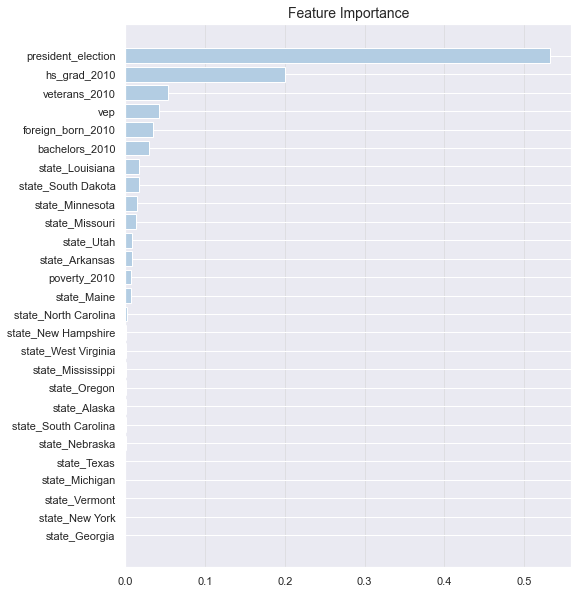

In [99]:
# get feature importance
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_reg_train, y_reg_train).feature_importances_, 
                   index=X_reg_train.columns, columns=['Importance']).sort_values('Importance')
imp = imp[imp['Importance'] > 0]
# plot feature importance
plt.figure(figsize=(8, 10))
plt.barh(range(0, len(imp)), imp['Importance'], color='#b3cde3')
plt.grid(axis='x', alpha=0.5, color='lightgrey')
plt.yticks(range(0, len(imp)), imp.index)
plt.title('Feature Importance', fontsize=14)
plt.show()

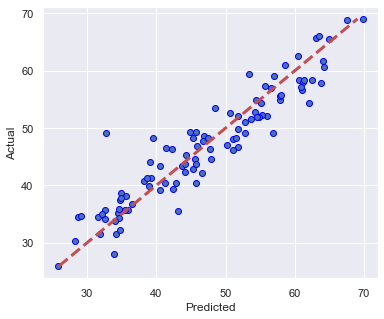

In [100]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_reg_test, edgecolors=(0, 0, 1))
ax.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

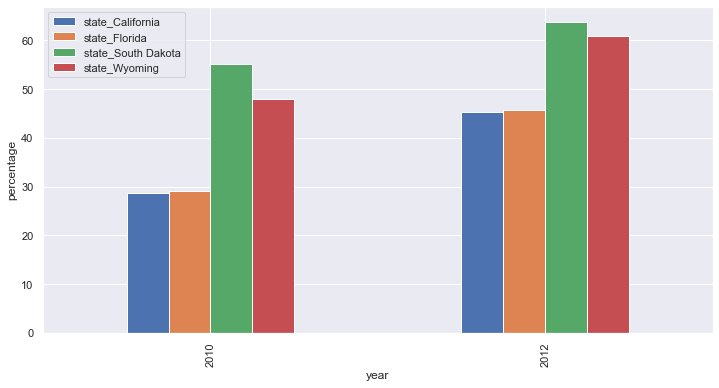

In [101]:
states_vis = X_reg_test.loc[['California', 'Florida', 'South Dakota', 'Wyoming']]
y_pred_vis = best.predict(states_vis)
states_vis['pred'] = y_pred_vis
states_vis = states_vis[['pred']]
states_vis.reset_index(inplace=True)
dummies = pd.get_dummies(states_vis,columns=['state'])
for index in states_vis.index:
    dummies['state_'+(states_vis['state'].loc[index])].loc[index] = dummies['pred'].loc[index]
dummies.groupby(['year']).sum().drop(columns=['pred']).plot.bar(figsize=(12, 6),ylabel='percentage');

In [102]:
compare = y_reg_test.copy()
compare['pred'] = y_pred
compare['deff'] = pow(compare['pred']-compare['turnout'],2)
Ranking = compare.groupby(['state']).sum() 
Ranking['Rank'] = Ranking["deff"].rank().astype('int')
Ranking[['Rank']].sort_values(by='Rank', ascending=True).tail(n=5)

,Rank
state,
Alaska,46
Nebraska,47
Kansas,48
Washington,49
Louisiana,50


<h3>KNeighborsRegressor</h3>

In [103]:
# define model
knn = KNeighborsRegressor()

# define parameter grid
parameters_grid = {
    'n_neighbors': [5, 10, 15, 25, 50],
    'weights': ['uniform', 'distance']
}

# define grid search
grid_search = GridSearchCV(estimator=knn, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_reg_train, y_reg_train)

# get best estimator
best = grid_search.best_estimator_

# print best parameters
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

,n_neighbors,weights
Selected Value,10,uniform


In [104]:
# predict
y_pred = best.predict(X_reg_test)

# calculate MSE
MSE = round(mean_squared_error(y_reg_test, y_pred), 3)
models_compare['KNeighborsRegressor'] = [MSE]
df = pd.DataFrame([MSE]).T
df = df.rename(index={0: 'KNN Regressor'}, columns={0: 'MSE'})
df

,MSE
KNN Regressor,84.656


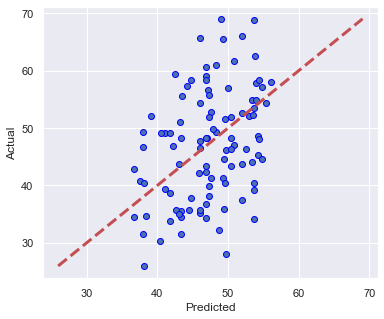

In [105]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_reg_test, edgecolors=(0, 0, 1))
ax.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

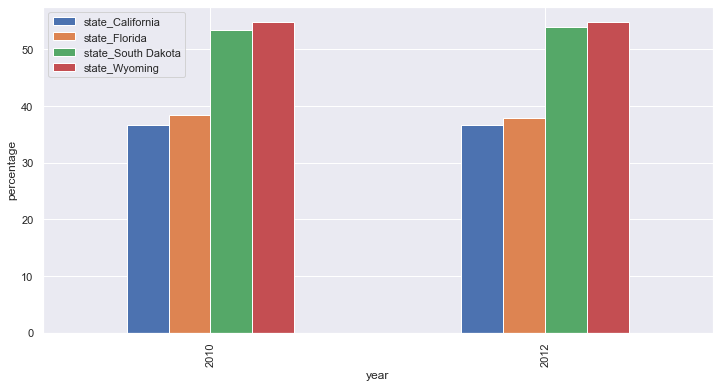

In [106]:
states_vis = X_reg_test.loc[['California', 'Florida', 'South Dakota', 'Wyoming']]
y_pred_vis = best.predict(states_vis)
states_vis['pred'] = y_pred_vis
states_vis = states_vis[['pred']]
states_vis.reset_index(inplace=True)
dummies = pd.get_dummies(states_vis,columns=['state'])
for index in states_vis.index:
    dummies['state_'+(states_vis['state'].loc[index])].loc[index] = dummies['pred'].loc[index]
dummies.groupby(['year']).sum().drop(columns=['pred']).plot.bar(figsize=(12, 6),ylabel='percentage');

In [107]:
compare = y_reg_test.copy()
compare['pred'] = y_pred
compare['deff'] = pow(compare['pred']-compare['turnout'],2)
Ranking = compare.groupby(['state']).sum() 
Ranking['Rank'] = Ranking["deff"].rank().astype('int')
Ranking[['Rank']].sort_values(by='Rank', ascending=True).tail(n=5)

,Rank
state,
Virginia,46
Iowa,47
Minnesota,48
Oklahoma,49
Hawaii,50


<h4>Comparing Regression Models</h4>
Based on MSE - who is more closer to zero is more accurate

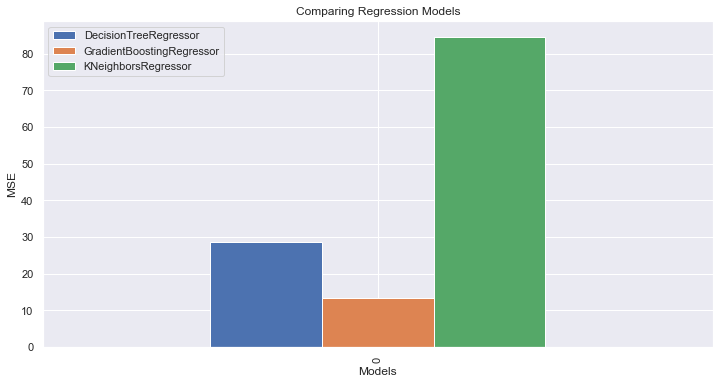

In [108]:
models_compare.plot.bar(figsize=(12, 6),ylabel='MSE',xlabel='Models',title='Comparing Regression Models');

Based of the gragh, GradientBoosting is the Best model

<h4>modifications to the model and features</h4>
We made modifications to our model so that the least 2 of the states<br>
that were in the bottom 5 will be ranked in the within the top 25 for prediction rate.

In [109]:
X_reg = total_votes_data.drop(columns=['totalvotes','turnout','president_election','hs_grad_2010'])
y_reg = total_votes_data[['year','turnout','state']]
y_reg['turnout'] = y_reg['turnout']*100
X_reg_train = X_reg[X_reg['year'] < 2010]
X_reg_test = X_reg[X_reg['year'] >= 2010]
y_reg_train = y_reg[y_reg['year'] < 2010]
y_reg_test = y_reg[y_reg['year'] >= 2010]
X_reg_train.set_index(['state','year'],inplace=True)
X_reg_test.set_index(['state','year'],inplace=True)
y_reg_train.set_index(['state','year'],inplace=True)
y_reg_test.set_index(['state','year'],inplace=True)

<h3>DecisionTreeRegressor</h3>

In [110]:
# define model
dt = DecisionTreeRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 4, 8]
}

# define grid search
grid_search = GridSearchCV(estimator=dt, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_reg_train, y_reg_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_reg_test)

In [111]:
compare = y_reg_test.copy()
compare['pred'] = y_pred
compare['deff'] = pow(compare['pred']-compare['turnout'],2)
Ranking = compare.groupby(['state']).sum() 
Ranking['Rank'] = Ranking["deff"].rank().astype('int')
Ranking[['Rank']].sort_values(by='Rank', ascending=True).head(n=25)

,Rank
state,
South Dakota,1
Alaska,2
California,3
West Virginia,4
Hawaii,5
Arizona,6
Oregon,7
New Mexico,8
Rhode Island,9


<h3>GradientBoostingRegressor</h3>

In [112]:
# define model
gb = GradientBoostingRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'learning_rate': [0.5, 1, 1.5],
    'n_estimators': [5, 15, 20]
}

# define grid search
grid_search = GridSearchCV(estimator=gb, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_reg_train, y_reg_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_reg_test)

In [113]:
compare = y_reg_test.copy()
compare['pred'] = y_pred
compare['deff'] = pow(compare['pred']-compare['turnout'],2)
Ranking = compare.groupby(['state']).sum() 
Ranking['Rank'] = Ranking["deff"].rank().astype('int')
Ranking[['Rank']].sort_values(by='Rank', ascending=True).head(n=25)

,Rank
state,
Alaska,1
California,2
West Virginia,3
Arizona,4
Oregon,5
Vermont,6
New Mexico,7
Rhode Island,8
Arkansas,9


<h3>KNeighborsRegressor</h3>

In [114]:
# define model
knn = KNeighborsRegressor()

# define parameter grid
parameters_grid = {
    'n_neighbors': [3, 6, 8, 16, 35],
    'weights': ['uniform', 'distance']
}

# define grid search
grid_search = GridSearchCV(estimator=knn, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_reg_train, y_reg_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_reg_test)

In [115]:
compare = y_reg_test.copy()
compare['pred'] = y_pred
compare['deff'] = pow(compare['pred']-compare['turnout'],2)
Ranking = compare.groupby(['state']).sum() 
Ranking['Rank'] = Ranking["deff"].rank().astype('int')
Ranking[['Rank']].sort_values(by='Rank', ascending=True).head(n=25)

,Rank
state,
South Dakota,1
California,2
Kansas,3
New Mexico,4
Alaska,5
South Carolina,6
Vermont,7
West Virginia,8
Nevada,9


# Section D (Classification) <a class="anchor" id="sectionD"></a>

Using the total votes counted by state in house elections<br>
we categories the state on that year as - D or R (DEMOCRAT or REPUBLICAN)

In [116]:
tmp = house_data[['year','state','party','candidatevotes']][(house_data['party']=='DEMOCRAT') | (house_data['party']=='REPUBLICAN')]
tmp['DEMOCRAT'] = 0
tmp['REPUBLICAN'] = 0
for i in tmp.index:
    tmp[tmp['party'].loc[i]].loc[i] = tmp['candidatevotes'].loc[i]
tmp = tmp.groupby(['year','state']).sum().reset_index()
tmp['Classified'] = ''
for index in tmp.index:
    if tmp['DEMOCRAT'].loc[index] > tmp['REPUBLICAN'].loc[index]:
        tmp['Classified'].loc[index] = 'D'
    else:
        tmp['Classified'].loc[index] = 'R'

We selected 10 fetures from county_complete

In [117]:
state_data = county_complete[['state','foreign_born_2010','foreign_spoken_at_home_2010','hs_grad_2010','bachelors_2010',
                 'veterans_2010','median_household_income_2010','poverty_2010','white_2019','black_2019',
                 'native_2019']]

In [118]:
party_count = pd.get_dummies(president_data,columns=['party_simplified']).groupby(['year','state']).sum()[['party_simplified_DEMOCRAT',
                                                                                                          'party_simplified_LIBERTARIAN',
                                                                                                          'party_simplified_OTHER',
                                                                                                          'party_simplified_REPUBLICAN']]


In [119]:
# tmp = tmp.set_index(['year','state']).join(party_count).reset_index().fillna(0)

In [120]:
tmp['president_election'] = ''

In [121]:
for i in tmp.index:
    if tmp['year'].loc[i] in president_year:
        tmp['president_election'].loc[i] = 'T'
    else:
        tmp['president_election'].loc[i] = 'F'

In [122]:
tmp = pd.get_dummies(tmp,columns=['president_election'])

In [123]:
tmp['state'] = tmp['state'].str.title()

In [124]:
state_data['state'] = state_data['state'].str.title()

In [125]:
state_data = state_data.groupby(['state']).mean()

In [126]:
mat = tmp.set_index(['state','year']).join(state_data).fillna(0)

In [127]:
for m in mat.index:
    state = state_data.loc[m[0]]
    for i in state_data.columns:
        mat[i].loc[m[0]] = state[i]

In [128]:
mat.reset_index(inplace=True)

In [129]:
mat.drop(columns=['candidatevotes','DEMOCRAT','REPUBLICAN'],inplace=True)

In [130]:
mat = pd.get_dummies(mat,columns=['state'])

In [131]:
X_cls = mat.drop(columns=['Classified'])
y_cls = mat[['Classified']]

In [132]:
# Split dataset into training set and test set
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X_cls, y_cls, test_size=0.3, random_state=RSEED)

In [133]:
results = []
models = []
kfold = KFold()

<h3>Support Victor Machine</h3>

In [134]:
# Split dataset into training set and test set
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X_cls, y_cls, test_size=0.25, random_state=RSEED)

In [135]:
sc = StandardScaler()

X_cls_train = sc.fit_transform(X_cls_train)
X_cls_test = sc.transform(X_cls_test)

clf = SVC(kernel='linear', C=1).fit(X_cls_train, y_cls_train)
cv_results = cross_val_score(clf, X_cls_test, y_cls_test, cv=5)
results.append(cv_results)
models.append('Support Victor Machine')

In [136]:
y_pred = clf.predict(X_cls_test)

cm = confusion_matrix(y_cls_test, y_pred)
print(cm)
accuracy_score(y_cls_test,y_pred)

[[113  29]
 [ 30 116]]


0.7951388888888888

<h3>RandomForestClassifier</h3>

In [137]:
# define model
rf = RandomForestClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 4, 6],
    'n_estimators': [20, 50, 80]
}

# define grid search
grid_search = GridSearchCV(estimator=rf, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_cls_train, y_cls_train)

# get best estimator
best = grid_search.best_estimator_

# print best parameters
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

,max_depth,min_samples_leaf,min_samples_split,n_estimators
Selected Value,5,4,2,50


In [138]:
cv_results = cross_val_score(rf, X_cls_train, y_cls_train, cv=kfold, scoring='accuracy')
results.append(cv_results)
models.append('RandomForest')

In [139]:
def get_metrics(y_test, y_pred):
    
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # get confusion matrix
    mat = metrics.confusion_matrix(y_test, y_pred)
    true_neg, false_pos, false_neg, true_pos = mat.ravel()
    
    # calculate sensitivity and specificity
    sensitivity = round(true_pos / np.sum(actual_pos), 3)
    specificity = round(true_neg / np.sum(actual_neg), 3)
    
    return sensitivity, specificity

In [140]:
# predict
y_pred = best.predict(X_cls_test)

# calculate metrics
acc = round(accuracy_score(y_cls_test, y_pred), 3)
sensitivity, specificity = get_metrics(y_cls_test, y_pred)

# display metrics
rf_df = pd.DataFrame([acc, sensitivity, specificity]).T
rf_df = rf_df.rename(index={0: 'Random Forest Classifier'}, columns={0: 'Accuracy', 1: 'Sensitivity', 2: 'Specificity'})
rf_df

,Accuracy,Sensitivity,Specificity
Random Forest Classifier,0.816,Classified inf dtype: float64,Classified inf dtype: float64


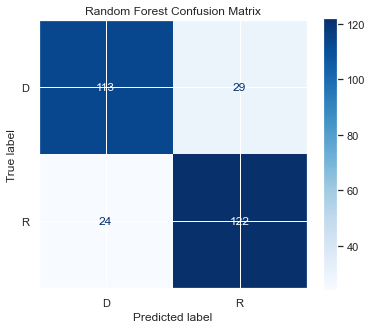

In [141]:
# plot confusion metrics
plot_confusion_matrix(best, X_cls_test, y_cls_test, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

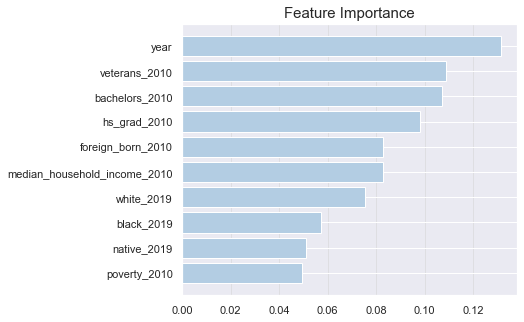

In [142]:
# get feature importance
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_cls_train, y_cls_train).feature_importances_, 
                   index=X_cls.columns, columns=['Importance']).sort_values('Importance')
imp = imp[imp['Importance'] > 0].tail(n=10)
# plot feature importance
plt.barh(range(0, len(imp)), imp['Importance'], color='#b3cde3')
plt.grid(axis='x', alpha=0.5, color='lightgrey')
plt.yticks(range(0, len(imp)), imp.index)
plt.title('Feature Importance', fontsize=15)
plt.show()

<h3>AdaBoostClassifier</h3>

In [143]:
# define model
ab = AdaBoostClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'n_estimators': [15,30]
}

# define grid search
grid_search = GridSearchCV(estimator=ab, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_cls_train, y_cls_train)


# get best estimator
best = grid_search.best_estimator_

# print best parameters
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

,n_estimators
Selected Value,15


In [144]:
cv_results = cross_val_score(ab, X_cls_train, y_cls_train, cv=kfold, scoring='accuracy')
results.append(cv_results)
models.append('AdaBoost')

In [145]:
# predict
y_pred = best.predict(X_cls_test)

In [146]:
# calculate accuracy
acc = round(accuracy_score(y_cls_test, y_pred), 3)

df = pd.DataFrame([acc]).T
df = df.rename(index={0: 'AdaBoost Classifier'}, columns={0: 'Accuracy'})
df

,Accuracy
AdaBoost Classifier,0.785


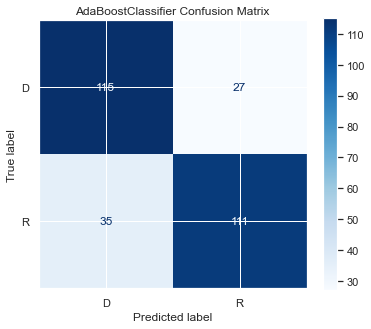

In [147]:
# plot confusion metrics
plot_confusion_matrix(best, X_cls_test, y_cls_test, cmap='Blues')
plt.title("AdaBoostClassifier Confusion Matrix")
plt.show()

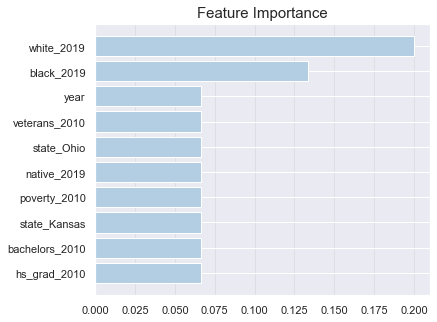

In [148]:
# get feature importance
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_cls_train, y_cls_train).feature_importances_, 
                   index=X_cls.columns, columns=['Importance']).sort_values('Importance')
imp = imp[imp['Importance'] > 0].tail(n=10)
# plot feature importance
plt.barh(range(0, len(imp)), imp['Importance'], color='#b3cde3')
plt.grid(axis='x', alpha=0.5, color='lightgrey')
plt.yticks(range(0, len(imp)), imp.index)
plt.title('Feature Importance', fontsize=15)
plt.show()

<h3>DecisionTreeClassifier</h3>

In [149]:
# define model
dt = DecisionTreeClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [2,4],
    'min_samples_split': [2,4,6,8],
    'min_samples_leaf': [2,4,8,10]
}

# define grid search
grid_search = GridSearchCV(estimator=dt, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_cls_train, y_cls_train)

# get best estimator
best = grid_search.best_estimator_

# print best parameters
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

,max_depth,min_samples_leaf,min_samples_split
Selected Value,4,2,2


In [150]:
cv_results = cross_val_score(dt, X_cls_train, y_cls_train, cv=kfold, scoring='accuracy')
results.append(cv_results)
models.append('DecisionTree')

In [151]:
# predict
y_pred = best.predict(X_cls_test)

# calculate accuracy
acc = round(accuracy_score(y_cls_test, y_pred), 3)
df = pd.DataFrame([acc]).T
df = df.rename(index={0: 'Decision Tree Classifier'}, columns={0: 'Accuracy'})
df

,Accuracy
Decision Tree Classifier,0.837


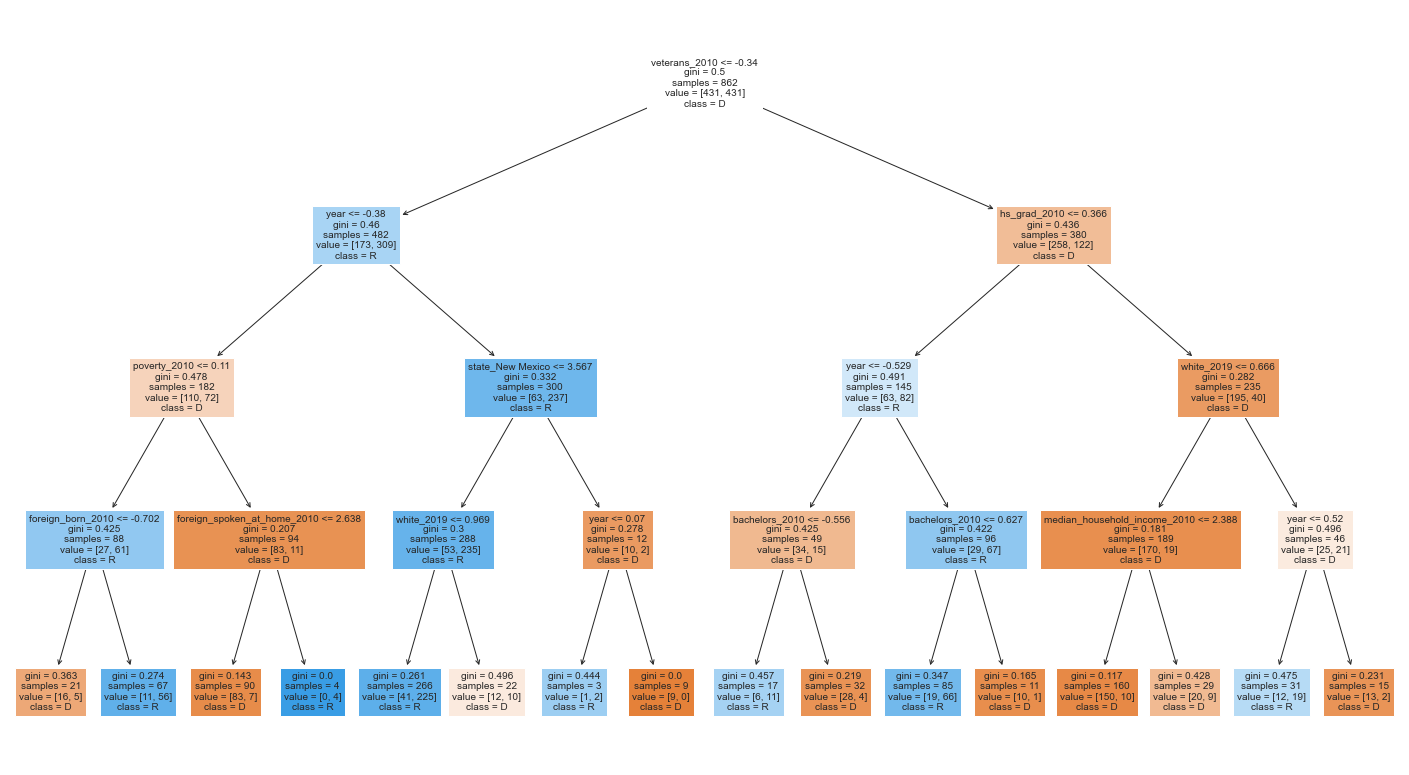

In [152]:
plt.figure(figsize=(25, 14))
tr = tree.plot_tree(best, feature_names=X_cls.columns, class_names=['D', 'R'], filled=True,fontsize=10)

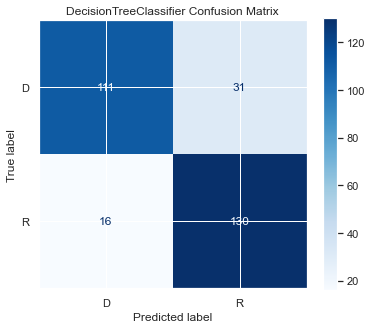

In [153]:
# plot confusion metrics
plot_confusion_matrix(best, X_cls_test, y_cls_test, cmap='Blues')
plt.title("DecisionTreeClassifier Confusion Matrix")
plt.show()

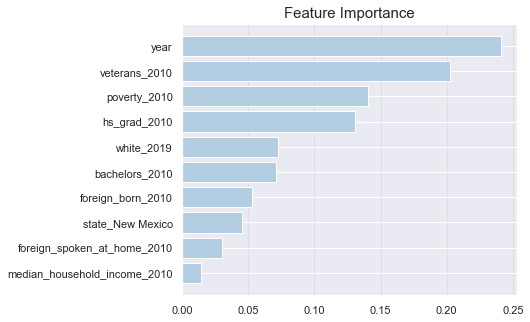

In [154]:
# get feature importance
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_cls_train, y_cls_train).feature_importances_, 
                   index=X_cls.columns, columns=['Importance']).sort_values('Importance')
imp = imp[imp['Importance'] > 0].tail(n=10)
# plot feature importance
plt.barh(range(0, len(imp)), imp['Importance'], color='#b3cde3')
plt.grid(axis='x', alpha=0.5, color='lightgrey')
plt.yticks(range(0, len(imp)), imp.index)
plt.title('Feature Importance', fontsize=15)
plt.show()

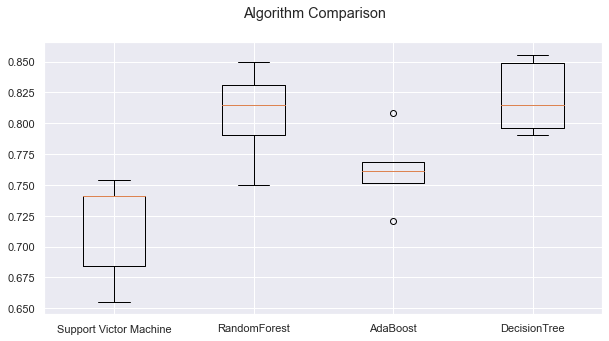

In [155]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models)
plt.show()